In [84]:
%load_ext sql
import statsmodels.api as sma
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import datetime
from scipy import stats
import math

from mpl_toolkits.basemap import Basemap # Basemap must be imported before Shapely due to conflict
import fiona
import shapely as shapely
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
from shapely.geometry import asShape
from time import gmtime, strftime
from array import array


# imports
import pandas as pd
import matplotlib.pyplot as plt
import csv
import math

# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import LinearRegression
import numpy as np

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import statsmodels.formula.api as sm

# this allows plots to appear directly in the notebook
%matplotlib inline

# city abbreviation code
city = 'hou'


The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [86]:
%sql mysql://root:@localhost/rental_nerd

u'Connected: root@rental_nerd'

In [87]:
query = %sql (\
SELECT  \
properties.id as 'property_id', \
properties.address,  \
properties.bedrooms,  \
properties.bathrooms,  \
properties.sqft,  \
properties.elevation,  \
(2016 - properties.year_built) as 'age',  \
properties.garage,  \
properties.level,  \
properties.zipcode, \
properties.has_pool, \
properties.home_type, \
properties.neighborhood, \
property_transaction_logs.id 'ptl_id',  \
property_transaction_logs.transaction_type,  \
property_transaction_logs.price,  \
property_transaction_logs.transaction_status,  \
property_transaction_logs.days_on_market,  \
property_transaction_logs.date_closed as 'date',  \
property_transaction_logs.date_listed \
FROM  \
properties,  \
property_transaction_logs \
WHERE  \
property_transaction_logs.property_id = properties.id AND  \
property_transaction_logs.transaction_type = "rental" AND  \
property_transaction_logs.date_closed is not null AND \
properties.zipcode LIKE '77%' AND \
properties.sqft > 0 AND \
properties.bedrooms IS NOT NULL AND \
properties.bathrooms IS NOT NULL AND \
properties.elevation IS NOT NULL AND \
properties.level IS NOT NULL AND \
properties.home_type IS NOT NULL AND \
properties.zipcode IS NOT NULL AND \
properties.sqft IS NOT NULL AND \
properties.year_built IS NOT NULL AND \
property_transaction_logs.price > 0 )
           
    
# properties.has_pool IS NOT NULL AND \
# properties.garage IS NOT NULL AND \
data = query.DataFrame()
data_copy = data

20749 rows affected.


In [88]:
data["year"] = pd.DatetimeIndex(data["date"]).to_period('A')

In [89]:
data["has_pool"] = data["has_pool"].apply(lambda x: True if x == 1.0 else False)

In [90]:
# filter out any outliers

print "Entries before filter: " + `len(data)`
data = data[  (data.sqft <= 10000) 
            & (data.price <= 6000) 
            & (data.price > 400)
            & (data.bedrooms <= 6) 
            & (data.bathrooms <= 6)]

print "Entries after filter: " + `len(data)`



Entries before filter: 20749
Entries after filter: 20092


In [91]:
data.describe() #identify filtering tresholds to clean up bad data

,property_id,bedrooms,bathrooms,sqft,elevation,age,garage,level,has_pool,ptl_id,price,days_on_market
count,20092.000000,20092.000000,20092.000000,20092.000000,20092.000000,20092.000000,20092.000000,20092.000000,20092,20092.000000,20092.000000,7893.000000
mean,2155315.897223,3.079783,2.085457,1947.832222,20.935266,35.494027,0.032451,1.133187,0.0381246,3450352.617211,1868.234621,197.012669
std,252487.877922,0.869205,0.768846,790.911037,10.815047,23.153538,0.177198,1.384219,0.191502,306151.453040,924.698516,398.257827
min,1886155.000000,0.000000,0.000000,1.000000,1.524940,0.000000,0.000000,1.000000,False,3006268.000000,425.000000,0.000000
25%,1917511.250000,3.000000,2.000000,1404.000000,15.534225,13.000000,0.000000,1.000000,0,3120566.500000,1275.000000,17.000000
50%,2065535.000000,3.000000,2.000000,1810.000000,19.100950,36.000000,0.000000,1.000000,0,3509858.500000,1600.000000,40.000000
75%,2364187.000000,4.000000,2.000000,2358.000000,24.976100,52.000000,0.000000,1.000000,0,3667561.750000,2200.000000,131.000000
max,2712986.000000,6.000000,6.000000,10000.000000,649.662000,139.000000,1.000000,51.000000,True,4910948.000000,6000.000000,2927.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10611bc50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x111bee550>]], dtype=object)

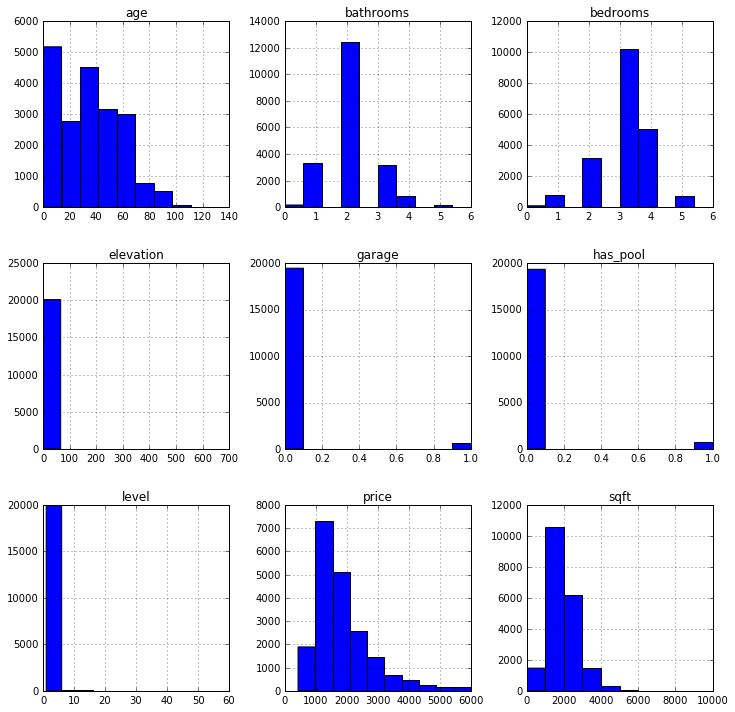

In [92]:
data.hist(column=['has_pool','bathrooms','bedrooms','price','garage','level','age','sqft','elevation'],figsize=(12,12))

In [93]:
# adjust variables so that for most houses they result in zero (or close to zero)
print "minimum elevation: " + `data.elevation.min()`
data.elevation = data.elevation - data.elevation.min()
data.level = data.level - 1
data.bathrooms = data.bathrooms - 1

minimum elevation: 1.52494


/usr/local/lib/python2.7/site-packages/pandas/core/generic.py:2273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [94]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    


In [ ]:
# Artnet white paper index converted to our dataset

# create year dummy variables (because date isn't very intuitive variable)
z = 'M'
data["period"] = pd.DatetimeIndex(data["date"]).to_period(z)
data['period_literal'] = pd.DatetimeIndex(data["date"]).to_period(z).format()

paired = data[['address','date','price','period','period_literal','zipcode', 'neighborhood']]

# identify the earliest date, number of periods, and number of pairs
base_period = paired.period.min()
num_periods = paired.period.max() - paired.period.min()
print "base period: " + `base_period` + " end period: " + `paired.period.max()` + " and number of periods: " + `num_periods`

# group data into Sets and calc Y_ist of each item
paired = paired.groupby("address").filter(lambda x: len(x) >1)
paired.sort_values(['address','period'],inplace=True)
paired_grp = paired.groupby('address')
print 'number of paired transactions in the data: ' + `paired.shape[0]`

In [ ]:
def demean(group):
    return pd.DataFrame({'address': group.address, 'original' : group.price, 'demeaned' : group.price - group.price.mean()})

# filter out properties with multiple listings in the same year and listings that moved by 20% or more
paired = paired.groupby(['address','period_literal']).filter(lambda x: len(x) == 1)
paired_grp = paired.groupby('address')
n = paired.groupby(['address']).apply(demean)
n = n[((n.demeaned / n.original).abs() > 0.10)]

paired = paired[~paired.address.isin(n.address)]

In [ ]:
boundary = 'neighborhood' # 'zipcode' or 'neighborhood'

table = ListTable()
table.append([boundary,'Period','Growth Rate','P Value','n'])

sorted_zips = []

# index used to calculate adjusted prices. 
iterables = [data[boundary].unique(), data.period.unique()]
mi = pd.MultiIndex.from_product(iterables, names=[boundary, 'period'])
price_adjustment_index = pd.Series()

In [ ]:
res = sm.ols(formula="np.log(price) ~ period + address", data=paired).fit()

#calculate index
linked = res.params[res.params.index.str.contains('Period')]
linked.name = "Index"
linked[0] = 100
num = pd.Series(linked, copy=True)
num[0] = 0
num.name = "n"
growth = pd.Series(linked, copy=True)
growth.name = "Growth Rate"
growth[0] = 0
for i in range(1,len(linked)):
    linked[i] = (np.exp(res.params[i]))*100
    growth[i] = linked[i]/linked[i-1] - 1
    num[i] = len(paired[paired.period_literal == filter(str.isdigit, linked.index[i])])

# add P values of each prediction
p = res.pvalues[res.params.index.str.contains('Period')] * 100
p.name = "P value"
index = pd.concat([linked, growth, p, num], axis=1)
index.index = pd.to_datetime(index.index.str.split("'").str.get(1)).to_period(z)

print index
# citywide index (will add neighborhoods in later calcs)
price_adjustment_index['city'] = index['Index']  



index[['Index']].plot()
# index[['Growth Rate']].plot()

In [ ]:
price_adjustment_index['city']

nan


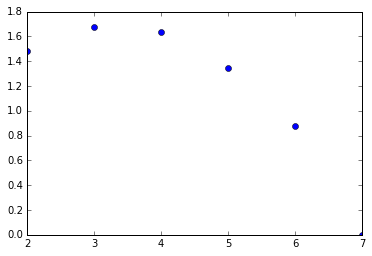

In [100]:
from numpy import *  
def hurst(p):  
    tau = []; lagvec = []  
    #  Step through the different lags  
    for lag in range(2,20):  
        #  produce price difference with lag  
        pp = subtract(p[lag:],p[:-lag])  
        #  Write the different lags into a vector  
        lagvec.append(lag)  
        #  Calculate the variance of the differnce vector  
        tau.append(sqrt(std(pp)))  
    #  linear fit to double-log graph (gives power)  
    m = polyfit(log10(lagvec),log10(tau),1)  
    # calculate hurst  
    hurst = m[0]*2  
    # plot lag vs variance  
    plt.plot(lagvec,tau,'o')
    return hurst  
if __name__=="__main__":  
    #  Different types of time series for testing  
#     p = log10(cumsum(random.randn(50000)+1)+1000) # trending, hurst ~ 1  
    #p = log10((random.randn(50000))+1000)   # mean reverting, hurst ~ 0  
#     p = log10(cumsum(random.randn(50000))+1000) # random walk, hurst ~ 0.5  
    print hurst(price_adjustment_index['city']) 

In [101]:
 def normcdf(X):
    (a1,a2,a3,a4,a5) = (0.31938153, -0.356563782, 1.781477937, -1.821255978, 1.330274429)
    L = abs(X)
    K = 1.0 / (1.0 + 0.2316419 * L)
    w = 1.0 - 1.0 / sqrt(2*pi)*exp(-L*L/2.) * (a1*K + a2*K*K + a3*pow(K,3) + a4*pow(K,4) + a5*pow(K,5))
    if X<0:
        w = 1.0-w
    return w
 
 
def vratio(a, lag = 2, cor = 'hom'):
    t = (std((a[lag:]) - (a[1:-lag+1])))**2;
    b = (std((a[2:]) - (a[1:-1]) ))**2;
 
    n = float(len(a))
    mu  = sum(a[1:n]-a[:-1])/n;
    m=(n-lag+1)*(1-lag/n);
#   print mu, m, lag
    b=sum(square(a[1:n]-a[:n-1]-mu))/(n-1)
    t=sum(square(a[lag:n]-a[:n-lag]-lag*mu))/m
    vratio = t/(lag*b);
 
    la = float(lag)
     
 
    if cor == 'hom':
        varvrt=2*(2*la-1)*(la-1)/(3*la*n)
 
 
    elif cor == 'het':
          varvrt=0;
          sum2=sum(square(a[1:n]-a[:n-1]-mu)); 
          for j in range(lag-1):
             sum1a=square(a[j+1:n]-a[j:n-1]-mu); 
             sum1b=square(a[1:n-j]-a[0:n-j-1]-mu)
             sum1=dot(sum1a,sum1b); 
             delta=sum1/(sum2**2);
             varvrt=varvrt+((2*(la-j)/la)**2)*delta
 
    zscore = (vratio - 1) / sqrt(float(varvrt))
    pval = normcdf(zscore);
 
    return  vratio, zscore, pval
 
if __name__=="__main__":
 
    trend = 0.25  #  The larger this number the stronger the trend, hence larger zscore and pval
    bias = 1000   #  This is to make sure that the time series does not go negative
    a = log((random.randn(1000)+bias)); #Mean reverting: hurst very small, vratio should be small
#    a = log(cumsum(random.randn(10000)+trend)+bias); #trending: hurst > 0.5;
#    a = log(cumsum(random.randn(10000)) + bias); #random walk: hurst ~ 0.5
 
    print vratio(price_adjustment_index['city'].values, cor = 'het', lag = 5)

(1.3151013309278179, 0.27175776672454316, 0.60709580060242463)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will r

only 49transactions in 77047
only 48transactions in Lazy Brook - Timbergrove
only 47transactions in Greater Greenspoint
only 47transactions in Greenway - Upper Kirby Area
only 45transactions in Meyerland Area
only 44transactions in 77086
only 44transactions in Willow Meadows - Willowbend Area
only 43transactions in Greater Inwood
only 43transactions in 77546
only 41transactions in Independence Heights
only 41transactions in Ost - South Union
only 40transactions in 77044
only 38transactions in Greater Fondren Southwest
only 37transactions in Astrodome Area
only 35transactions in Midtown
only 33transactions in 77049
only 33transactions in Fort Bend - Houston
only 33transactions in University Place
only 32transactions in Fourth Ward
only 30transactions in East Little York - Homestead
only 30transactions in Greater Fifth Ward
only 30transactions in Braeswood Place
only 27transactions in 77090
only 27transactions in Lake Houston
only 26transactions in Afton Oaks - River Oaks Area
only 25tra

/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


neighborhood,Period,Growth Rate,P Value,n
Greater Heights,2016,1.02,6.35,278
Central Southwest,2016,4.1,63.34,172
Clear Lake,2016,3.3,0.21,158
77066,2016,2.15,4.94,157
77014,2016,0.82,0.62,153
77095,2016,1.1,0.01,151
Oak Forest - Garden Oaks,2016,3.66,0.0,145
Neartown - Montrose,2016,-0.4,0.38,134
Eldridge - West Oaks,2016,-0.89,57.82,131
Greater Uptown,2016,4.53,64.0,130


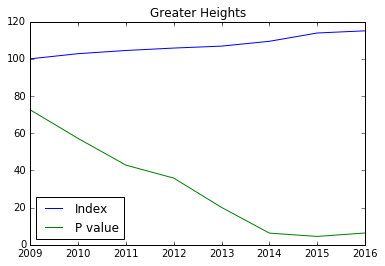

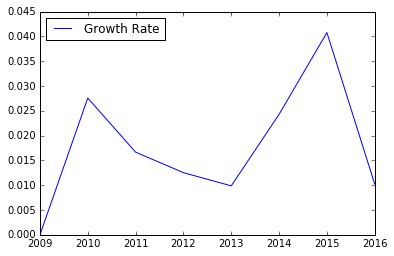

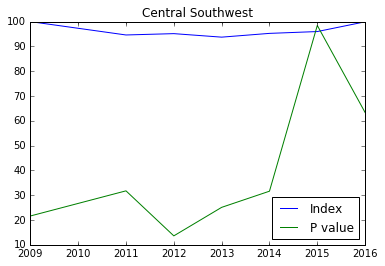

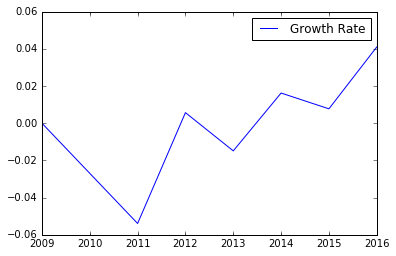

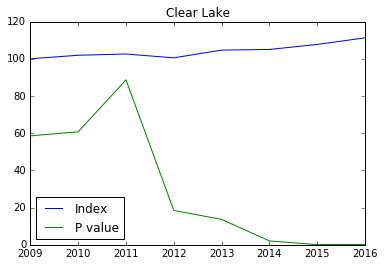

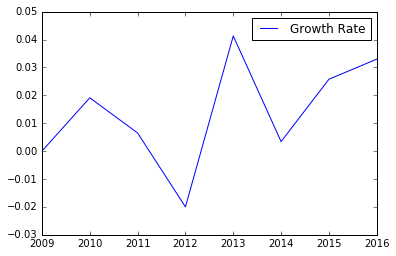

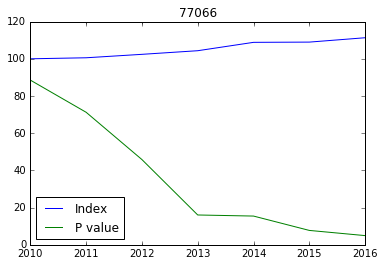

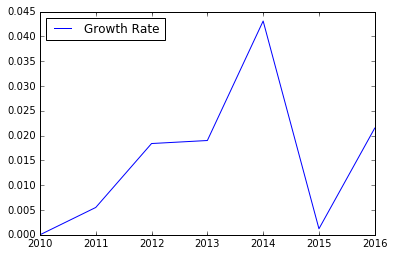

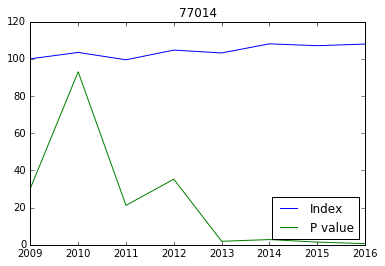

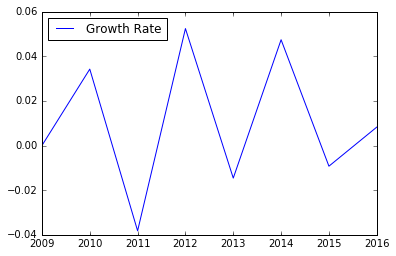

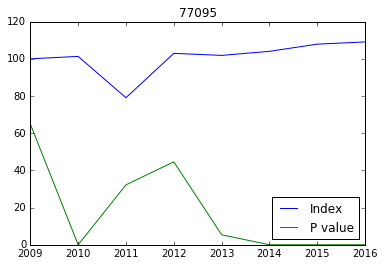

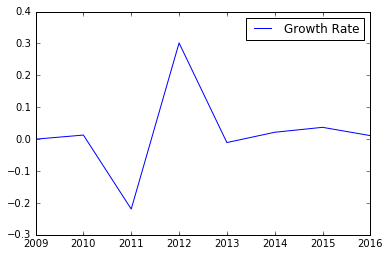

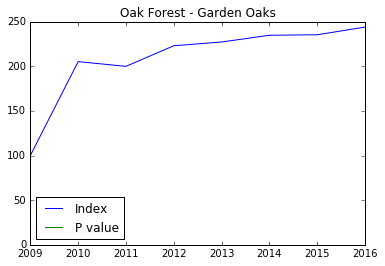

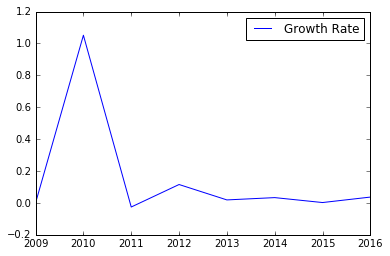

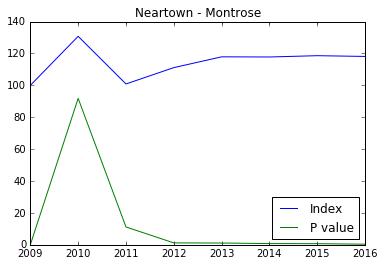

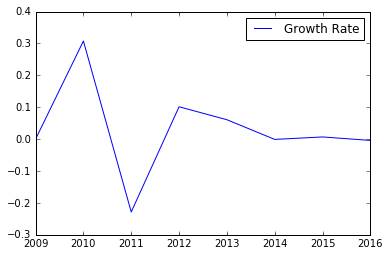

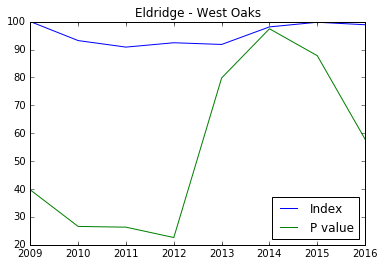

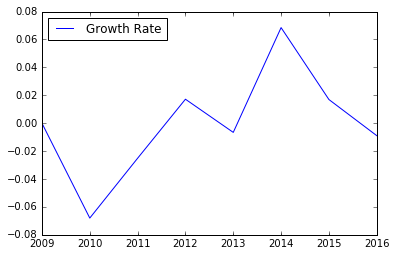

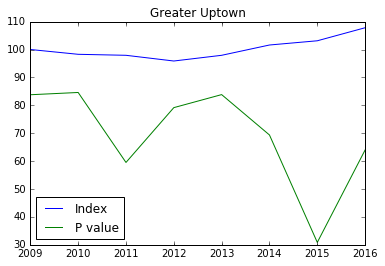

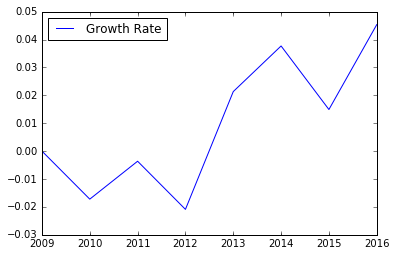

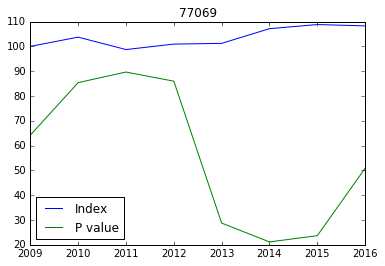

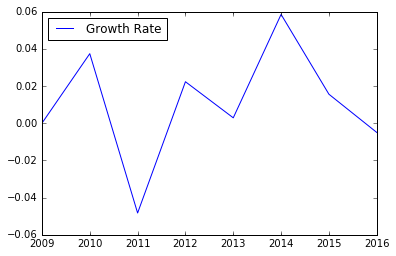

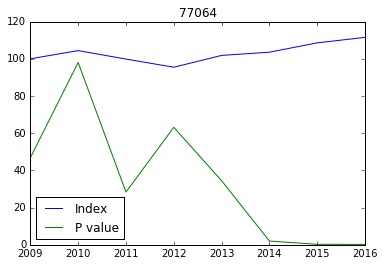

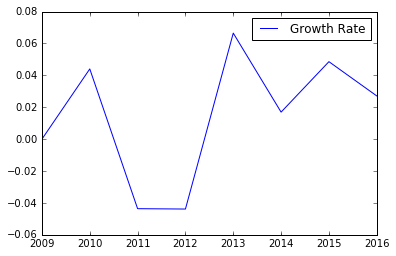

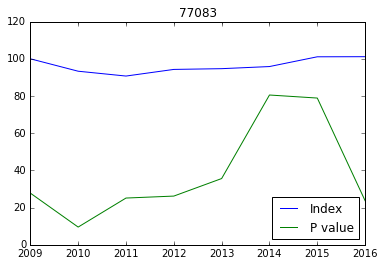

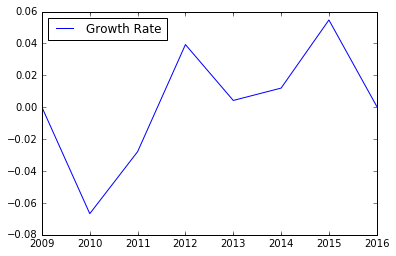

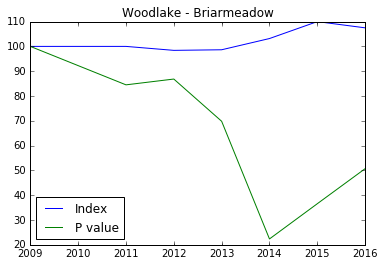

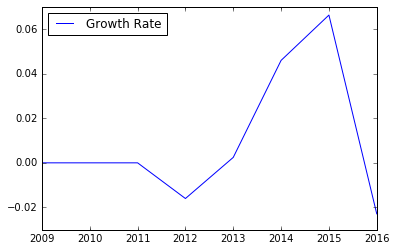

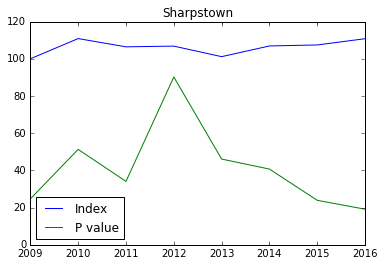

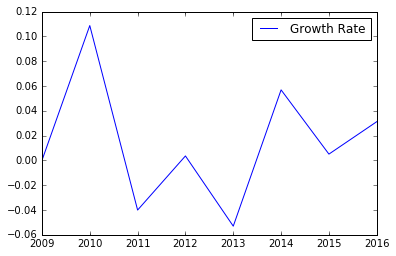

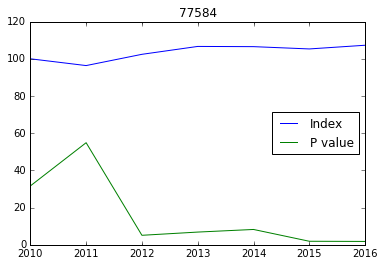

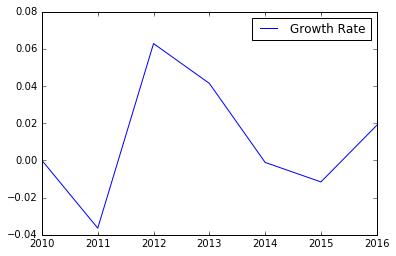

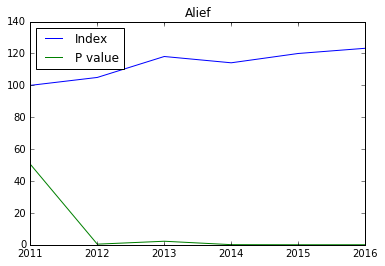

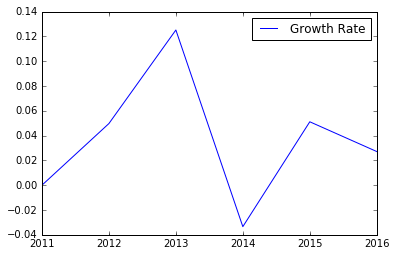

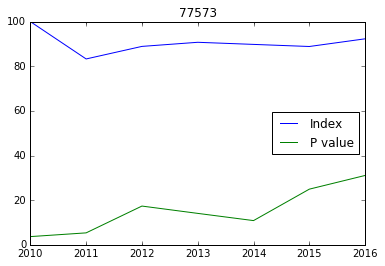

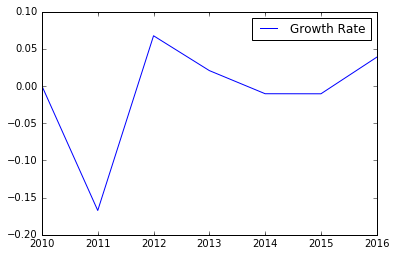

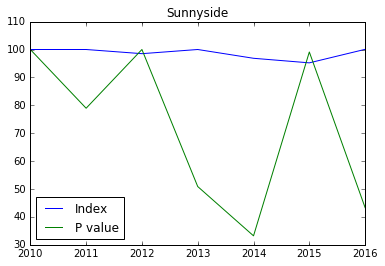

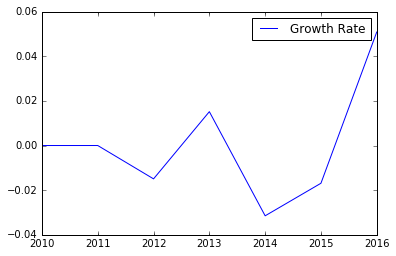

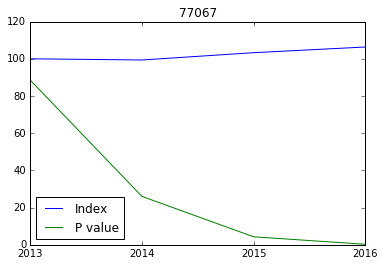

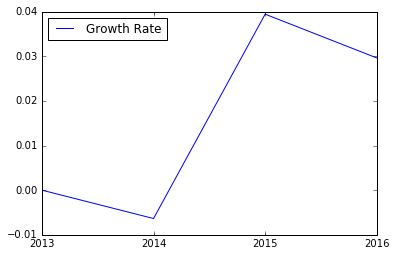

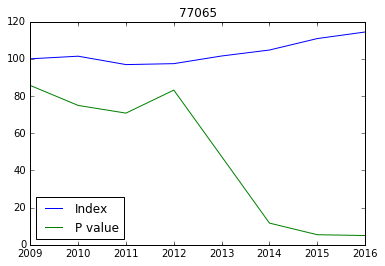

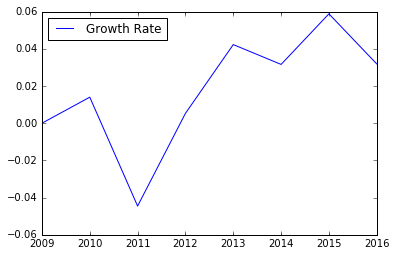

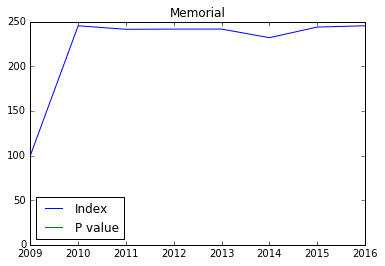

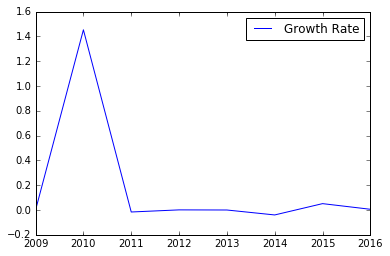

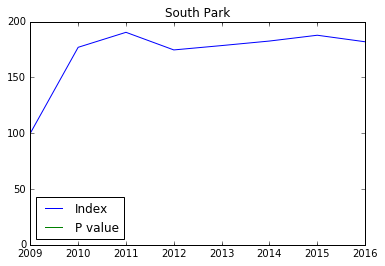

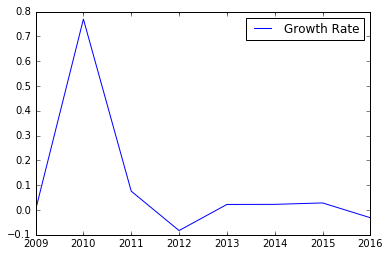

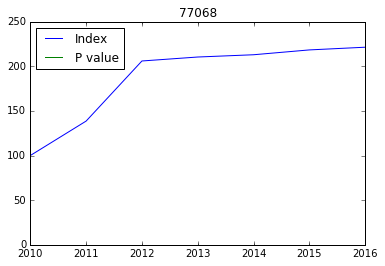

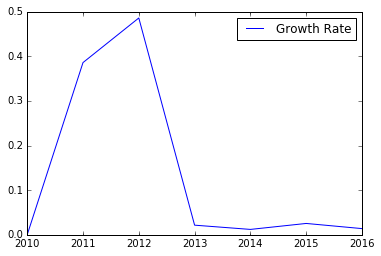

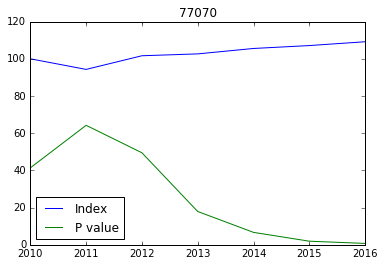

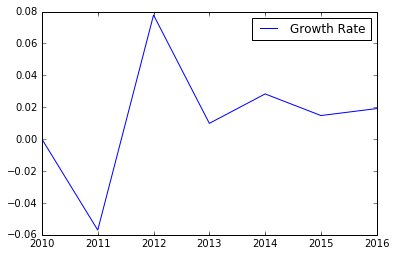

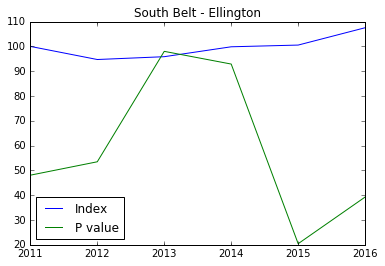

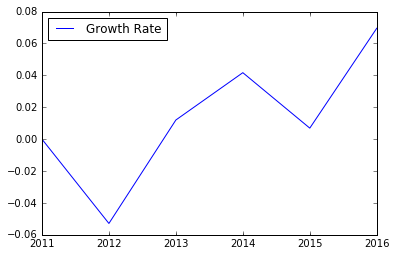

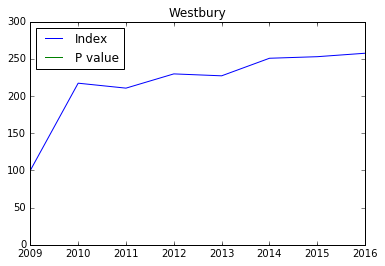

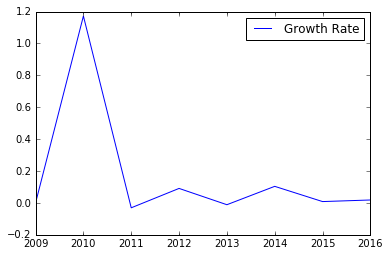

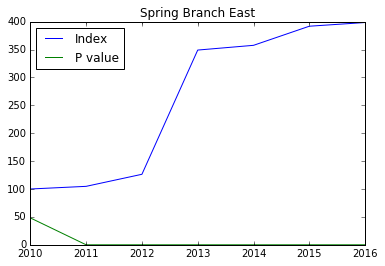

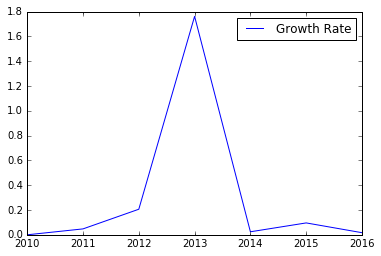

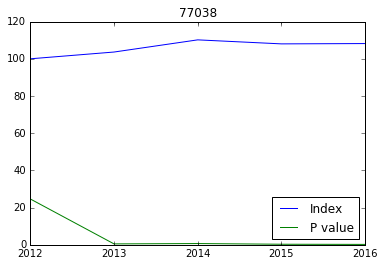

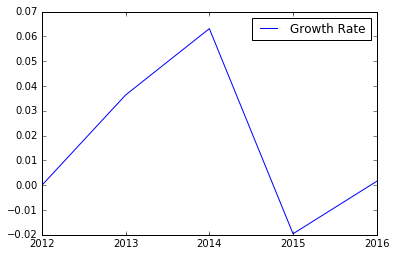

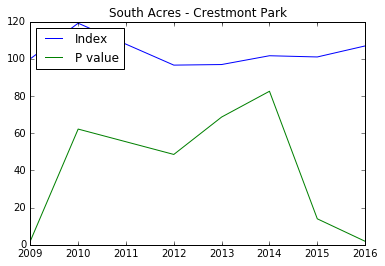

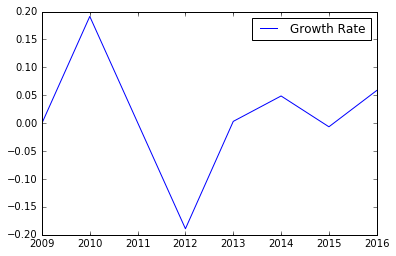

In [102]:
for hood in paired[boundary].unique():
    sorted_zips.append([hood, len(paired[paired[boundary] == hood])])
    
for hood, n in sorted(sorted_zips, key =lambda x: x[1], reverse=True):
    d = paired[paired[boundary] == hood]
    if len(d) < 50:
        print 'only ' + `len(d)` + 'transactions in ' + hood
        continue

    res = sm.ols(formula="np.log(price) ~ period + address", data=d).fit()

    #calculate index
    linked = res.params[res.params.index.str.contains('Period')]
    linked.name = "Index"
    linked[0] = 100
    
    growth = pd.Series(linked, copy=True)
    growth.name = "Growth Rate"
    growth[0] = 0
    for i in range(1,len(linked)):
        linked[i] = (np.exp(res.params[i]))*100
        growth[i] = linked[i]/linked[i-1] - 1

    # add P values of each prediction
    p = res.pvalues[res.params.index.str.contains('Period')] * 100
    p.name = "P value"
    index = pd.concat([linked, growth, p], axis=1)
    
    index.index = pd.to_datetime(index.index.str.split("'").str.get(1)).to_period(z)
    
    # update the price adjustment index to be used for later regressions
    price_adjustment_index[hood] = index['Index']  
    
    last = index.tail(1)
    table.append([hood
                  ,last.index[0]
                  ,round(last.iloc[0]['Growth Rate'] * 100,2)
                  ,round(last.iloc[0]['P value'], 2)
                  ,n])

    index[['Index','P value']].plot(title=hood)
    index[['Growth Rate']].plot()

table

In [103]:
def g(listing): 
#     print 'price: ' + `listing.price`
#     print 'year: ' + `listing.year`
#     print 'hood: ' + listing[boundary]
    try:
        index_value = price_adjustment_index[listing[boundary]][listing.year] / price_adjustment_index[listing[boundary]][2016]
    except KeyError:
        try:
            index_value = price_adjustment_index['city'][listing.year] / price_adjustment_index['city'][2016]
        except KeyError:
            index_value = 1
#     print index_value
    indexed_price = listing.price * index_value
#     print 'adj price: ' + `indexed_price`
    
    return indexed_price
    

In [104]:
indexed_price = data.apply(g, axis=1)
indexed_price.name = "indexed_price"
data = pd.concat([data,indexed_price],axis=1)

In [105]:
data[['indexed_price','price','year']].head()

,indexed_price,price,year
3,2995.000000,2995,2016
4,2995.000000,2995,2016
16,4200.000000,4200,2016
17,2870.499591,3100,2012
18,3442.358746,3500,2015


In [106]:
import datetime
out_of_sample_data = data[data.date > (datetime.date.today() - datetime.timedelta(days=7))]
# out_of_sample_data.reset_index(inplace=True)
print "number of transactions in data: " + `len(data)` + "\texcluding latest " + `len(out_of_sample_data)` + " transactions"
in_sample_data = data[~data.date.isin(out_of_sample_data.date)]
print "number of transactions in data after exclusion: " + `len(in_sample_data)`


number of transactions in data: 20092	excluding latest 0 transactions
number of transactions in data after exclusion: 20092


In [107]:
for z in set(out_of_sample_data.zipcode.unique()).difference(in_sample_data.zipcode.unique()):
    print("shoving missing zipcode into in_sample_data : ?", z)
    in_sample_data = in_sample_data.append(out_of_sample_data[out_of_sample_data.zipcode == z].head(1)) 

In [108]:
# dist_to_park unit is 1 degree of latitude or 69 miles north south or 54 miles east west

result = sm.ols(formula="indexed_price ~ bedrooms + bathrooms + elevation + level + age + has_pool + garage + home_type:zipcode:sqft", data=in_sample_data).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          indexed_price   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     231.0
Date:                Mon, 26 Dec 2016   Prob (F-statistic):               0.00
Time:                        13:25:14   Log-Likelihood:            -1.5314e+05
No. Observations:               20092   AIC:                         3.067e+05
Df Residuals:                   19874   BIC:                         3.084e+05
Df Model:                         217                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Intercept                            658.9793     20.880     31.560      0.000       618.053   699.906
has_pool[T.True]                      25.0347     18.949      1.321      0.186       -12.107    62.177
bedrooms                              65.5643      6.070     10.801      0.000        53.666    77.463
bathrooms                            161.6258      6.894     23.443      0.000       148.112   175.140
elevation                             -2.1819      0.519     -4.204      0.000        -3.199    -1.165
level                                 -7.8711      2.748     -2.865      0.004       -13.257    -2.486
age                                   -1.8081      0.203     -8.901      0.000        -2.206    -1.410
garage                                48.0191     21.000      2.287      0.022         6.857    89.182
home_type[mfh]:zipcode[77002]:sqft     0.9458      0.253      3.732      0.000         0.449     1.442
home_type[sfh]:zipcode[77002]:sqft     1.1158      0.175      6.390      0.000         0.774     1.458
home_type[mfh]:zipcode[77003]:sqft     0.5942      0.027     22.319      0.000         0.542     0.646
home_type[sfh]:zipcode[77003]:sqft     0.6238      0.042     14.822      0.000         0.541     0.706
home_type[mfh]:zipcode[77004]:sqft     0.6199      0.027     22.990      0.000         0.567     0.673
home_type[sfh]:zipcode[77004]:sqft     0.5837      0.029     19.787      0.000         0.526     0.642
home_type[mfh]:zipcode[77005]:sqft     0.9019      0.034     26.446      0.000         0.835     0.969
home_type[sfh]:zipcode[77005]:sqft     1.0240      0.071     14.329      0.000         0.884     1.164
home_type[mfh]:zipcode[77006]:sqft     0.8877      0.018     48.976      0.000         0.852     0.923
home_type[sfh]:zipcode[77006]:sqft     0.7729      0.022     35.827      0.000         0.731     0.815
home_type[mfh]:zipcode[77007]:sqft     0.7698      0.045     16.950      0.000         0.681     0.859
home_type[sfh]:zipcode[77007]:sqft     0.6983      0.062     11.253      0.000         0.577     0.820
home_type[mfh]:zipcode[77008]:sqft     0.6156      0.023     26.893      0.000         0.571     0.660
home_type[sfh]:zipcode[77008]:sqft     0.7772      0.012     62.796      0.000         0.753     0.801
home_type[mfh]:zipcode[77009]:sqft     0.4493      0.051      8.830      0.000         0.350     0.549
home_type[sfh]:zipcode[77009]:sqft     0.6523      0.020     33.369      0.000         0.614     0.691
home_type[mfh]:zipcode[77010]:sqft     2.5310      0.308      8.213      0.000         1.927     3.135
home_type[sfh]:zipcode[77010]:sqft   8.34e-11   2.97e-12     28.123      0.000      7.76e-11  8.92e-11
home_type[mfh]:zipcode[77011]:sqft     0.1189      0.067      1.782      0.075        -0.012    

In [109]:
print list(set(in_sample_data.zipcode.unique()).difference(out_of_sample_data.zipcode.unique()))

print list(set(out_of_sample_data.zipcode.unique()).difference(in_sample_data.zipcode.unique()))



['77047', '77046', '77045', '77044', '77043', '77042', '77041', '77040', '77083', '77082', '77081', '77573', '77089', '77049', '77048', '77003', '77002', '77088', '77007', '77006', '77005', '77004', '77532', '77009', '77530', '77536', '77071', '77477', '77017', '77076', '77336', '77478', '77339', '77074', '77087', '77075', '77050', '77051', '77053', '77054', '77055', '77056', '77057', '77058', '77059', '77565', '77086', '77060', '77018', '77571', '77014', '77015', '77016', '77084', '77010', '77011', '77012', '77013', '77069', '77068', '77449', '77085', '77381', '77070', '77025', '77024', '77027', '77026', '77021', '77020', '77023', '77022', '77061', '77520', '77063', '77062', '77029', '77028', '77067', '77521', '77008', '77065', '77450', '77598', '77064', '77094', '77095', '77096', '77090', '77091', '77092', '77093', '77066', '77098', '77099', '77345', '77546', '77036', '77037', '77034', '77035', '77032', '77033', '77030', '77031', '77072', '77504', '77505', '77502', '77077', '77038', 

In [110]:
for z in set(in_sample_data.zipcode.unique()).difference(out_of_sample_data.zipcode.unique()):
    print("shoving missing zipcode into out_of_sample_data : ?", z)
    out_of_sample_data = out_of_sample_data.append(in_sample_data[in_sample_data.zipcode == z].head(1)) 

('shoving missing zipcode into out_of_sample_data : ?', '77047')
('shoving missing zipcode into out_of_sample_data : ?', '77046')
('shoving missing zipcode into out_of_sample_data : ?', '77045')
('shoving missing zipcode into out_of_sample_data : ?', '77044')
('shoving missing zipcode into out_of_sample_data : ?', '77043')
('shoving missing zipcode into out_of_sample_data : ?', '77042')
('shoving missing zipcode into out_of_sample_data : ?', '77041')
('shoving missing zipcode into out_of_sample_data : ?', '77040')
('shoving missing zipcode into out_of_sample_data : ?', '77083')
('shoving missing zipcode into out_of_sample_data : ?', '77082')
('shoving missing zipcode into out_of_sample_data : ?', '77081')
('shoving missing zipcode into out_of_sample_data : ?', '77573')
('shoving missing zipcode into out_of_sample_data : ?', '77089')
('shoving missing zipcode into out_of_sample_data : ?', '77049')
('shoving missing zipcode into out_of_sample_data : ?', '77048')
('shoving missing zipcode

In [111]:
print len(out_of_sample_data.zipcode.unique())
print len(in_sample_data.zipcode.unique())

121
121


In [112]:
import patsy
x = patsy.dmatrix("bedrooms + bathrooms + elevation + level + age + has_pool + garage + home_type:zipcode:sqft", data=out_of_sample_data) 
p = result.predict(x, transform=False)
print 'length of prediction from .predict ' + `len(p)`
pprice_out = pd.Series(p)
pprice_out.name = "prediction"
print pprice_out.head()
print 'length of prediction price ' + `len(pprice_out)`
print 'length of out of sample ' + `len(out_of_sample_data)`
errors_out = out_of_sample_data.price.values - pprice_out
errors_out.name = 'error'
print errors_out.head()


length of prediction from .predict 121
0    2410.256011
1    2600.000000
2    1168.379157
3    1622.804313
4    2633.150592
Name: prediction, dtype: float64
length of prediction price 121
length of out of sample 121
0    5.897440e+02
1    1.787157e-10
2    1.266208e+02
3    7.719569e+01
4    1.668494e+02
Name: error, dtype: float64


In [113]:
print 'length of OOS data: ' + `len(out_of_sample_data)`
print 'length of prediction: ' + `len(pprice_out)`
out_of_sample_data.reset_index(drop=True, inplace=True)
out_of_sample_result = pd.concat([out_of_sample_data,pprice_out,errors_out],axis=1)



length of OOS data: 121
length of prediction: 121


In [114]:
print 'length of out of sample data ' + `len(out_of_sample_result)`
print 'length of predicted price of OOS data ' + `len(pprice_out)`
print 'length of error of OOS data ' + `len(errors_out)`

length of out of sample data 121
length of predicted price of OOS data 121
length of error of OOS data 121


In [115]:
out_of_sample_result[['address','price','prediction','error','zipcode']].head()

,address,price,prediction,error,zipcode
0,"14923 Hooper Rd, Houston, TX 77047",3000,2410.256011,5.897440e+02,77047
1,"3787 Richmond Ave # 1165, Houston, TX 77046",2600,2600.000000,1.787157e-10,77046
2,"14415 Cannata Dr, Houston, TX 77045",1295,1168.379157,1.266208e+02,77045
3,"13047 Iris Garden Ln, Houston, TX 77044",1700,1622.804313,7.719569e+01,77044
4,"11734 Wickhollow Ln, Houston, TX 77043",2800,2633.150592,1.668494e+02,77043


In [116]:
percent_errors_out = (1.0 * out_of_sample_result.error.abs() / out_of_sample_result.price)
percent_errors_out.name = 'error'

print percent_errors_out.median()

hooderrors_out = out_of_sample_result[['zipcode']]
hooderrors_out = pd.concat([hooderrors_out,errors_out.abs()],axis=1)
hood_group_out = hooderrors_out.groupby('zipcode')

0.0790658489696


                error    
               median len
zipcode                  
77002    6.430128e-10   1
77003    5.610769e+01   1
77004    2.794613e+02   1
77005    2.656849e+02   1
77006    1.453367e+02   1


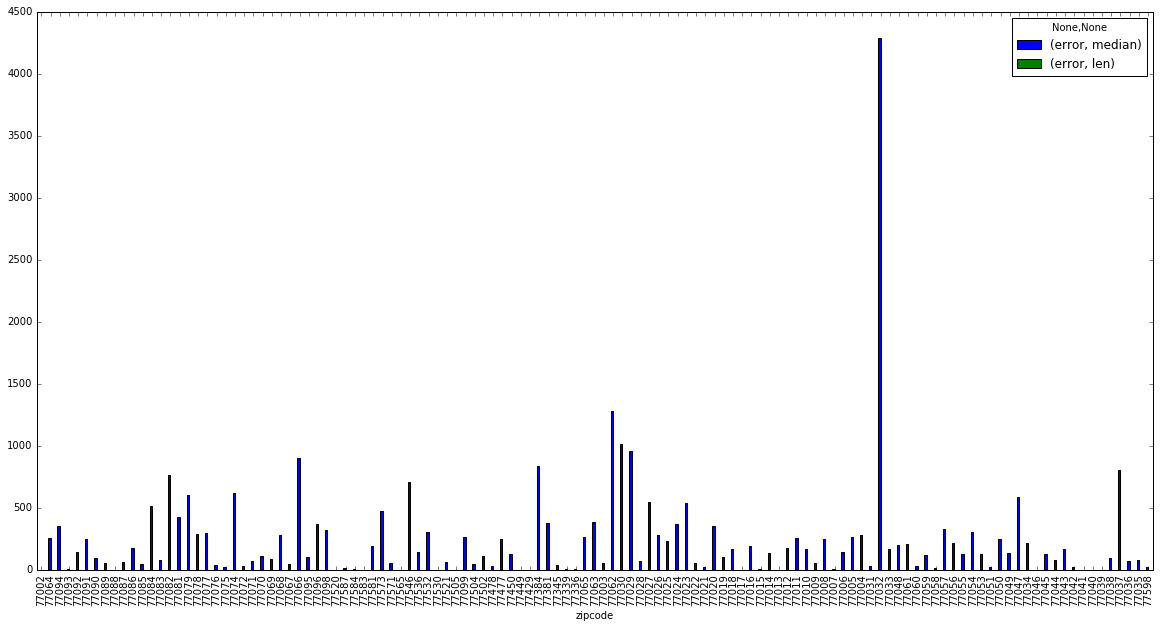

In [117]:
error_avg_out = hood_group_out.agg([np.median,len])
print error_avg_out.head()
error_avg_out.sort_values(by=('error','len'),ascending=False,inplace=True)
error_avg_out.plot(kind='bar',figsize=(20,10))

In [118]:
output = [['zipcode','sfh','multifamily']]
table = ListTable()
table.append(output[0])

for row in data.zipcode.unique():
    output_row = [row, '99', '99']
    for i in result.params.index:
        if 'zipcode' not in i: continue

        if 'zipcode[' + row + ']' in i:
            if 'home_type[mfh]' in i:
                output_row[2] = `result.params[i]`
                output.append(output_row)
                table.append(output_row)

            if 'home_type[sfh]' in i:
                output_row[1] = `result.params[i]`

table

zipcode,sfh,multifamily
77027,0.75859036214269993,1.1162996281321247
77019,0.85157924331612322,0.68104605032297072
77006,0.77290202394015828,0.88769062580224523
77098,0.86103970053639045,0.70874923824863523
77023,0.55299637673673119,0.12926768820310386
77017,0.22041226714535939,7.8048150436813013e-05
77024,1.3735108516755679,0.9367747327272653
77079,0.79873046195800346,0.41114144870354458
77055,0.62594200481670836,0.44814442970299306
77018,0.64061840187990804,0.34811702109307996


In [119]:
path = 'rentalnerd_importer/lib/tasks/model_files/'

with open(path + 'model_zipcode_' + city + '.csv', 'wb') as csvfile:
    hoodwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    for i in output:
        hoodwriter.writerow(i)

In [120]:
dtype = [('Effect', 'S100'), ('Coefficient', float)]

with open(path + 'model_features_' + city + '.csv', 'wb') as csvfile:
    modelwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)

    header = ['Effect','Coefficient']
    table.append(header)
    modelwriter.writerow(header)
    modelwriter.writerow(['base_rent', result.params.Intercept])
    modelwriter.writerow(['bedrooms', result.params.bedrooms])
    modelwriter.writerow(['bathrooms', result.params.bathrooms])
    modelwriter.writerow(['elevation', result.params.elevation])
    modelwriter.writerow(['level', result.params.level])
    modelwriter.writerow(['age', result.params.age])
    modelwriter.writerow(['garage', result.params.garage])
    modelwriter.writerow(['has_pool', result.params['has_pool[T.True]']])
    modelwriter.writerow(['mean square error of residuals', result.mse_resid])

result.cov_params().to_csv(path + 'model_covs_' + city + '.csv')

In [121]:
# output = [['district_id','coefficient']]
# table = ListTable()
# table.append(output[0])

# for row in sorted(data.school_district_id.unique()):
#     output_row = [row, '99']
#     for i in result.params.index:
#         if 'school_district_id' not in i: continue

#         if 'school_district_id)[T.' + `row` + ']' in i:
#             output_row[1] = `result.params[i]`
#             output.append(output_row)
#             table.append(output_row)

# table

In [122]:
# with open(path + 'model_schools_houston.csv', 'wb') as csvfile:
#     schoolswriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
#     for i in output:
#         schoolswriter.writerow(i)

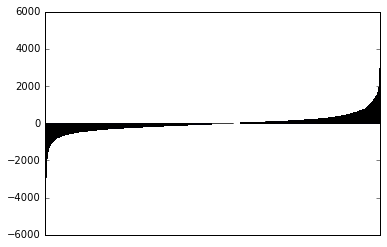

In [ ]:
errors = result.resid
errors.name = 'error'
pprice = data.indexed_price - errors
pprice.name = "prediction"
data = pd.concat([data, errors], axis=1)
data = pd.concat([data, pprice], axis=1)

# visualize the relationship between the features and the response using scatterplots
errors.sort_values(inplace=True)
errors.plot(kind='bar').get_xaxis().set_ticks([])

# show errors by neighborhood to see if there are any neighborhoods with funky differences

hooderrors = data[['zipcode']]
hooderrors = pd.concat([hooderrors,errors.abs()],axis=1)
hood_group = hooderrors.groupby('zipcode')

In [ ]:
error_avg = hood_group.agg([np.median,len])
error_avg.sort_values(by=('error','len'),ascending=False,inplace=True)
error_avg.plot(kind='bar',figsize=(20,10))

In [ ]:
# show errors by year to see if there are any years with funky differences
yearerrors = data[['year']]
percent_errors = (1.0 * errors.abs() / data.price)
percent_errors.name = 'error'
yearerrors = pd.concat([yearerrors,percent_errors],axis=1)

year_group = yearerrors.groupby('year')
error_avg = year_group.median()
error_avg.plot(kind='bar')
print error_avg
